In [299]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import torchvision
import torchvision.datasets as datasets
from torch import nn
from torch import optim

device='cuda'

In [300]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [301]:
X_te=mnist_testset.data               ## Test set images
y_te=mnist_testset.test_labels        ## Test set labels

N_o=10                                ## Number of output nodes/classes
N_te=y_te.size()[0]                   ## Number of test samples
Y_te=torch.zeros([N_te,N_o])          ## Initialisation of the one-hot encoded labels for the test set
Y_te[np.arange(0,N_te),y_te]=1        ## From labels to one-hot encoded labels for the test set

X_tr=mnist_trainset.data              ## Train set images
y_tr=mnist_trainset.train_labels      ## Train labels 
N_tr=y_tr.size()[0]                   

Y_tr=torch.zeros([N_tr,N_o])          ## Initialisation of one-hot encoded labels for training
Y_tr[np.arange(0,N_tr),y_tr]=1        ## From labels to one-hot encoded labels for the training set

N_val=10000                           ## Here I take out N_val samples from the training set and use them for validation
i_val=np.random.permutation(np.arange(0,N_tr))[0:N_val]

X_val=X_tr[i_val,:,:]
Y_val=Y_tr[i_val,:]

i_tr=np.delete(np.arange(0,N_tr),i_val)
N_tr=N_tr-N_val

X_tr=X_tr[i_tr,:,:]
Y_tr=Y_tr[i_tr,:]

T=X_tr.size()[2]
N_in=X_tr.size()[1]

## Normalisation and conversion to float
X_M=255

X_tr=(X_tr.float()/X_M).to(device)
X_val=(X_val.float()/X_M).to(device)
X_te=(X_te.float()/X_M).to(device)

Y_tr=Y_tr.float().to(device)
Y_val=Y_val.float().to(device)
Y_te=Y_te.float().to(device)
# Y_tr=torch.tile(Y_tr.float().unsqueeze(2),[1,1,X_tr.size()[2]]).to(device)
# Y_val=torch.tile(Y_val.float().unsqueeze(2),[1,1,X_tr.size()[2]]).to(device)
# Y_te=torch.tile(Y_te.float().unsqueeze(2),[1,1,X_tr.size()[2]]).to(device)


/its/home/jb739/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/its/home/jb739/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [302]:
def Data2Classes(X,Y):
    
    ind=torch.where(Y==1)[1]

    nClass=torch.max(ind)+1
    
    X1=[]
    Y1=[]
    
    for n in range(nClass):
    
        ind1=torch.where(ind==n)[0].type(torch.long)

        X1.append(torch.clone(X[ind1,:]).to(device))
        Y1.append(torch.clone(Y[ind1,:]).to(device))
        
    return X1, Y1
        
# X_tr/X_val/X_te are lists of length 10 (1 entry per class)
X_tr, Y_tr=Data2Classes(X_tr,Y_tr)

X_val, Y_val=Data2Classes(X_val,Y_val)

X_te, Y_te=Data2Classes(X_te,Y_te)

In [305]:
class Model_James(nn.Module):
    
    def __init__(self,N,N_in,N_av,alpha,rho,gamma,Ns,fb_ind,batch_size,nClass):
        super().__init__()
        
        
        self.N=N
        self.alpha=torch.tensor(alpha,device=device)
        self.rho=rho
        self.N_av=N_av
        self.N_in=N_in
        self.gamma=gamma
        
        diluition=1-N_av/N
        W=np.random.uniform(-1,1,[N,N])
        W=W*(np.random.uniform(0,1,[N,N])>diluition)
        eig=np.linalg.eigvals(W)
        self.W=torch.from_numpy(self.rho*W/(np.max(np.absolute(eig)))).float().to(device)
        
        self.x=[]
        
        if self.N_in==1:
            
            self.W_in=2*np.random.randint(0,2,[self.N_in,self.N])-1
            self.W_in=torch.from_numpy(self.W_in*self.gamma,device=device).float()
            
            
        else:
            
            self.W_in=np.random.randn(self.N_in,self.N)
            self.W_in=torch.from_numpy(self.gamma*self.W_in).float().to(device)
            
        
        self.Ws=[]
        self.bs=[]
        self.Ns=Ns
        
        for n in range(1,np.shape(Ns)[0]):
            
            self.Ws.append(nn.Parameter(torch.randn([Ns[n-1],Ns[n]],device=device)/torch.sqrt(Ns[n-1]+Ns[n])))
            self.bs.append(nn.Parameter(torch.zeros([Ns[n]],device=device)))
        
        self.fb_ind=fb_ind
        
        self.W_fb=[]
        self.W_fb.append(nn.Parameter(torch.randn([Ns[fb_ind],Ns[0]],device=device)/torch.sqrt(Ns[n-1]+Ns[n])))
    
        # Useful hyperparameters
        self.nClass=nClass
        self.batch_size = batch_size
        self.nSampPerClassPerBatch = int(batch_size/nClass) # No. input samples per class, per batch
        # # Setup target vector to compute Loss and Accuracy
        # self.target = torch.zeros(self.batch_size).long().to(device)
        # for j in range(1,nClass):
        #     self.target[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch] = j
        # Setup one-hot encoded target vector to compute Loss and Accuracy
        self.target = torch.zeros(self.batch_size, nClass, dtype=torch.float32).to(device)
        for j in range(1,nClass):
            self.target[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch,j] = 1.
    
    def Initialize_Hyper(self,eta):
        
        self.eta=eta
        
        self.opt=optim.Adam([{ 'params': self.Ws+self.bs+self.W_fb, 'lr':eta }])
    
    
    def Reset(self,s):
        
        batch_size=s.size()[0]
        self.x=torch.zeros([batch_size,self.N],device=device)
        self.xs=[]
        self.xs.append(self.x)
        
        for n in range(1,np.shape(self.Ns)[0]-1):
            
            self.xs.append(torch.zeros([batch_size,self.Ns[n]],device=device))
            if n==self.fb_ind:
                
                self.fb=torch.clone(self.xs[n])
        
    def Forward(self,s):
        
        
        self.x=(1-self.alpha)*self.x+self.alpha*torch.tanh(torch.matmul(s,self.W_in)+torch.matmul(self.x,self.W)+\
                                                          torch.matmul(self.fb,self.W_fb[0]))
        
        self.xs[0]=self.x
        for n in range(1,np.shape(self.Ns)[0]-1):
            

            self.xs[n]=torch.relu(torch.matmul(self.xs[n-1],self.Ws[n-1])+self.bs[n-1])
            
            if n==self.fb_ind:
                
                self.fb=torch.clone(self.xs[n])
    
        
    def Response(self,Input,Targets):
        
        T=Input.shape[2]
        Out=torch.zeros([Input.shape[0],self.Ns[-1],T],device=device)
        
        self.Reset(Input[:,0,0])
        
        loss=nn.BCEWithLogitsLoss()
        
        for t in range(T):

            self.Forward(Input[:,:,t])
            
            Out[:,:,t]=torch.matmul(self.xs[-1],self.Ws[-1])+self.bs[-1]
            
        Err=loss(Out[:,:,-1],Targets)

        Err.backward(retain_graph=True)

        Acc=torch.mean( torch.eq(torch.argmax(Targets,1),torch.argmax(Out[:,:,-1],1)).float() )                           

        self.opt.step()
        self.opt.zero_grad()
            
        return Out, Err, Acc
    
    def Set_Transfer(self,Ns_transfer,eta_transfer):
        
        self.Ws_t=[]
        self.bs_t=[]
        self.Ns_transfer=Ns_transfer
        
        for n in range(1,np.shape(Ns_transfer)[0]):
            
            self.Ws_t.append(nn.Parameter(torch.randn([Ns_transfer[n-1],Ns_transfer[n]],device=device)/torch.sqrt(Ns_transfer[n-1]+Ns_transfer[n])))
            self.bs_t.append(nn.Parameter(torch.zeros([Ns_transfer[n]],device=device)))
        
        self.opt_tr=optim.Adam([{ 'params': self.Ws_t+self.bs_t, 'lr':eta_transfer}])

    def Transfer(self,Input,Targets):
        
        T=Input.shape[2]
        X=torch.zeros([Input.shape[0],self.Ns[-2]],device=device)
        self.Reset(Input[:,0,0])
        
        loss=nn.BCEWithLogitsLoss()
        
        with torch.no_grad():
        
            for t in range(T):

                self.Forward(Input[:,:,t])
                
            X=torch.clone(self.xs[-1])
        
        Xs_transfer=[]
        Xs_transfer.append(X)
        
        for n in range(1,np.shape(self.Ns_transfer)[0]-1):
            
            Xs_transfer.append(torch.relu(torch.matmul(self.Xs_transfer[n-1],self.Ws_t[n-1])+self.bs_t[n-1]))
            
        Out=torch.matmul(Xs_transfer[-1],self.Ws_t[-1])+self.bs_t[-1]
        
        Err=loss(Out,Targets)
        
        Err.backward(retain_graph=True)

        Acc=torch.mean( torch.eq(torch.argmax(Targets,1),torch.argmax(Out,1)).float() )                           

        self.opt_tr.step()
        self.opt_tr.zero_grad()
            
        return Out, Err, Acc
    
    def generateBatch(self, method, X):
       
        ### For normal batches, e.g. for transfer learning
        if method=='simple':
            batch = torch.zeros(self.batch_size, X[0].shape[1], X[0].shape[2], dtype=torch.float32, requires_grad=False).to(device)
            self.target = torch.zeros(self.batch_size, self.nClass, dtype=torch.float32).to(device)
            # for j in range(self.batch_size):
            #     ind1 = torch.randint(0,self.nClass,[1])
            #     ind2 = torch.randint(0,X[ind1].shape[0],[1])
            #     batch[j,:,:] = torch.clone(X[ind1][ind2,:,:])
            #     self.target[j,ind1] = 1.
            for k in range(self.nClass):
                rand_ind=np.random.randint(0,X[k].shape[0],(self.nSampPerClassPerBatch,))
                batch[k*self.nSampPerClassPerBatch:(k+1)*self.nSampPerClassPerBatch,:,:] = torch.clone(X[k][rand_ind,:,:])
                self.target[k*self.nSampPerClassPerBatch:(k+1)*self.nSampPerClassPerBatch, k] = 1
        ### For triplet loss
        if method=='tripletLoss':
            
            # Populate batch
            batch = torch.zeros([3*self.batch_size, self.nInputs,self.tMax]).to(device)
            for k in range(self.nClass):
                # Random indeces to select samples (2 for anchor and positive, then 1 for negative)
                ind_ap = np.random.choice(X[k].shape[0],(self.nSampPerClassPerBatch,2), replace=False)
                # Populate Anchor and Positive samples
                batch[k*self.nSampPerClassPerBatch:(k+1)*self.nSampPerClassPerBatch,:] = torch.clone(X[k][ind_ap[:,0],:])
                batch[self.batch_size+k*self.nSampPerClassPerBatch:self.batch_size+(k+1)*self.nSampPerClassPerBatch,:] = torch.clone(X[k][ind_ap[:,1],:])
                # Populate negative samples
                randClass = np.random.choice((np.arange(self.nClass)!=k).nonzero()[0], self.nSampPerClassPerBatch)
                for m, cl in enumerate(randClass):
                    batch[2*self.batch_size + k*self.nSampPerClassPerBatch+m,:] = torch.clone(X[cl][np.random.randint(X[cl].shape[0]),:])
            
        ### For Protoypical Loss
        if method=='prototypicalLoss':
            batch = torch.zeros((self.nP+self.nQ)*self.nClass, X[0].shape[1], X[0].shape[2]).to(device)
            for j, x in enumerate(X): # For each class (X is a list)
                ind = np.random.choice(x.shape[0], self.nP+self.nQ, replace=False)
                batch[j*self.nP:(j+1)*self.nP,:] = torch.clone(x[ind[:self.nP],:])
                batch[self.nP*self.nClass+j*self.nQ:self.nP*self.nClass+(j+1)*self.nQ] = torch.clone(x[ind[self.nP:],:])

        return batch
                           
   
    

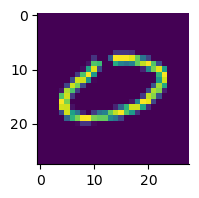

In [108]:
batch = NN.generateBatch('simple',X_tr)
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
j=-8
pl.imshow(batch[j,:,:].squeeze().numpy())

In [306]:
N_in=X_tr[0].size()[1]
N=500
N_av=10
alpha=0.8
rho=0.99
gamma=0.1
Ns=torch.tensor([500,100,10])
fb_ind=1

eta=0.001
N_train=5000
batch_size=50
nClass = 10
NN=Model_James(N, N_in, N_av, alpha, rho, gamma, Ns, fb_ind, batch_size, nClass)
NN.Initialize_Hyper(eta)

Err=torch.zeros([N_train])
Acc=torch.zeros([N_train])

for n in range(N_train):
    
    batch = NN.generateBatch('simple',X_tr)
    
    out, err, acc=NN.Response(batch,NN.target)
    
    Err[n]=err.detach().to('cpu')
    Acc[n]=acc.detach().to('cpu')
    
    if n%250==0:
        
        print(torch.mean(Err[n-100:n]), torch.mean(Acc[n-100:n]))
        


    

tensor(nan) tensor(nan)
tensor(0.1887) tensor(0.5880)
tensor(0.1241) tensor(0.7734)
tensor(0.0968) tensor(0.8352)
tensor(0.0794) tensor(0.8682)
tensor(0.0683) tensor(0.8878)
tensor(0.0633) tensor(0.8946)
tensor(0.0595) tensor(0.9016)
tensor(0.0617) tensor(0.8954)
tensor(0.0515) tensor(0.9190)
tensor(0.0480) tensor(0.9216)
tensor(0.0419) tensor(0.9320)
tensor(0.0445) tensor(0.9258)
tensor(0.0436) tensor(0.9310)
tensor(0.0419) tensor(0.9302)


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    NN.Reset(X_tr)
    for t in range(28):
        NN.Forward(X_tr[:,:,t])
    X=torch.clone(NN.xs[-1])

In [ ]:
fig = pl.figure(figsize=tuple(np.array((20.,10.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
ind=(torch.argmax(Y_tr[:,:,0], 1)==3).nonzero().squeeze()
pl.plot(X[ind[0:10],:].cpu().transpose(0,1), c=[1,0,0])
ind=(torch.argmax(Y_tr[:,:,0], 1)==4).nonzero().squeeze()
pl.plot(X[ind[0:10],:].cpu().transpose(0,1), c=[0,0,1])
pl.show()

In [ ]:
Ns_transfer=torch.clone(Ns[-2:])

N_transfer=1000
Err_t=torch.zeros([N_transfer])
Acc_t=torch.zeros([N_transfer])

eta_transfer=0.001
NN.Set_Transfer(Ns_transfer,eta_transfer)


for n in range(N_transfer):
    
    rand_ind=np.random.randint(0,X_tr.size()[0],[batch_size])
    X_b=X_tr[rand_ind,:,:]
    Y_b=Y_tr[rand_ind,:]
    
    out, err, acc=NN.Transfer(X_b,Y_b)
    
    Err_t[n]=err.detach().to('cpu')
    Acc_t[n]=acc.detach().to('cpu')
    
    if n%250==0:
        
        print(torch.mean(Err_t[n-100:n]), torch.mean(Acc_t[n-100:n]))
        